Este es ejemplo de cómo abordar el problema utilizando un algoritmo genético en Python para minimizar los costos de distribución de dinero en cajeros automáticos.

Utilizaremos la librería deap (Distributed Evolutionary Algorithms in Python) para implementar el algoritmo genético.

El conjunto de datos de entrada es el que resulta como salida del modelo predictivo **atm_predicted_demand.csv**

In [36]:
!pip install deap

In [49]:
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

**Carga de datos:** Lee los datos desde atm_predicted_demand.csv.

In [38]:
# Cargar datos
data = pd.read_csv('atm_predicted_demand.csv')
data.head()

,ATM_ID,Date,Predicted_Soles_Withdrawn,Predicted_Dollars_Withdrawn
0,1,2023-01-08,22706.45,7315.45
1,1,2023-01-09,28769.62,11668.74
2,1,2023-01-10,17118.18,3645.71
3,1,2023-01-11,44497.24,9774.27
4,1,2023-01-12,26394.47,4577.91


**Definición de parámetros:** Configura los valores máximos y los costos asociados con operación, falta y exceso de dinero.

In [39]:
# Definir parámetros del problema
NUM_CAJEROS = len(data)  # Número de cajeros automáticos
MAX_SALES = 1000000  # Valor máximo de soles o dólares en un cajero
MAX_DOLLARS = 300000  # Valor máximo de dólares en un cajero

# Costos (se pueden ajustar estos valores según sea el caso)
COST_OPERATION = 0.1  # Costos de operación por unidad de dinero
COST_LACK = 1.0  # Costo por falta de dinero
COST_EXCESS = 0.5  # Costo por exceso de dinero

**Función de evaluación:** Calcula el costo total para un individuo dado. La función considera los costos de operación, falta y exceso de dinero.

In [40]:
# Definir la función de costo
def evaluate(individual):
    total_cost = 0

    for i in range(NUM_CAJEROS):
        soles = individual[i]
        dollars = individual[NUM_CAJEROS + i]

        # Costos de operación
        cost_operation = (soles + dollars) * COST_OPERATION

        # Costos asociados con la falta de dinero
        cost_lack = max(0, data.loc[i, 'Predicted_Soles_Withdrawn'] - soles) * COST_LACK + \
                    max(0, data.loc[i, 'Predicted_Dollars_Withdrawn'] - dollars) * COST_LACK

        # Costos asociados con el exceso de dinero
        cost_excess = max(0, soles - data.loc[i, 'Predicted_Soles_Withdrawn']) * COST_EXCESS + \
                      max(0, dollars - data.loc[i, 'Predicted_Dollars_Withdrawn']) * COST_EXCESS

        total_cost += cost_operation + cost_lack + cost_excess

    return total_cost,

**Configuración del algoritmo genético:** Configura el algoritmo genético usando deap, definiendo los operadores de cruzamiento, mutación y selección.

In [41]:
# Configuración del algoritmo genético
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register('attr_float', random.uniform, 0, MAX_SALES)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_float, n=2 * NUM_CAJEROS)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

toolbox.register('evaluate', evaluate)
toolbox.register('mate', tools.cxBlend, alpha=0.5)
toolbox.register('mutate', tools.mutPolynomialBounded, low=0, up=MAX_SALES, eta=0.5, indpb=0.2)
toolbox.register('select', tools.selTournament, tournsize=3)

# Configuración de la población y algoritmos
population = toolbox.population(n=50)
NGEN = 50
CXPB, MUTPB = 0.5, 0.2

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


**Ejecución del algoritmo:** Ejecuta el algoritmo genético para encontrar el mejor individuo.

In [42]:
# Algoritmo genético
for gen in range(NGEN):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.register('mutate', tools.mutPolynomialBounded, low=0, up=MAX_SALES, eta=20, indpb=0.2)
            del mutant.fitness.values

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = toolbox.select(population + offspring, len(population))


In [43]:
# Obtener el mejor individuo
best_individual = tools.selBest(population, 1)[0]
print('Mejor individuo:', best_individual)
print('Costo mínimo:', evaluate(best_individual)[0])


Mejor individuo: [63424.60052472532, 698549.6255577785, 89183.33652478294, 449859.710468058, 924566.6819542239, 435115.2275740351, 191502.5187345881, 205786.00244554871, 421528.01157552435, 255302.15983604256, 411097.8144008213, 923963.1997354747, 359053.07716677483, 665143.1790014979, 273553.27676084463, 196513.68855365185, 92769.33052756553, 499325.7526744779, 731307.6680212561, 87718.69303903867, 944437.506206417, 400981.799638082, 801382.9842986593, 786800.8738866634, 552643.5412977017, 648975.8425998354, 230699.60344697925, 514353.88951220305, 74843.1472379798, 142276.0576487878, 498333.0689345058, 985081.0073313493, 486013.6441953657, 703807.5099692236, 116969.1179366229, 236260.9646962267, 441094.97992377065, 869011.2262081973, 740065.8501534304, 388529.0734023322, 789993.0277618335, 339970.3462597843, 476005.78125884844, 609459.7006578663, 38715.137435401004, 571117.6083701114, 84519.05439807572, 282939.54800210707, 755715.3379827344, 147536.23660330984, 746122.2617303361, 4778

**Ajuste de valores:** Asegura que los valores óptimos para cada cajero no excedan los valores predichos.

In [44]:
# Ajustar los valores para que no excedan los valores predichos
optimal_values = []
for i in range(NUM_CAJEROS):
    soles = min(best_individual[i], data.loc[i, 'Predicted_Soles_Withdrawn'])
    dollars = min(best_individual[NUM_CAJEROS + i], data.loc[i, 'Predicted_Dollars_Withdrawn'])
    optimal_values.append((soles, dollars))

**Guardar resultados:** Exporta los valores óptimos a un archivo CSV llamado atm_predicted_demand_with_optimal_costs.csv.

In [45]:
# Añadir los resultados óptimos al dataframe original
data['optimal_soles'] = [soles for soles, dollars in optimal_values]
data['optimal_dollars'] = [dollars for soles, dollars in optimal_values]

In [46]:
data.head(20)

,ATM_ID,Date,Predicted_Soles_Withdrawn,Predicted_Dollars_Withdrawn,optimal_soles,optimal_dollars
0,1,2023-01-08,22706.45,7315.45,22706.45,7315.45
1,1,2023-01-09,28769.62,11668.74,28769.62,11668.74
2,1,2023-01-10,17118.18,3645.71,17118.18,3645.71
3,1,2023-01-11,44497.24,9774.27,44497.24,9774.27
4,1,2023-01-12,26394.47,4577.91,26394.47,4577.91
5,1,2023-01-13,32873.63,11664.40,32873.63,11664.40
6,1,2023-01-14,19165.56,7230.99,19165.56,7230.99
7,1,2023-01-15,27340.52,6041.50,27340.52,6041.50
8,1,2023-01-16,34261.67,17504.45,34261.67,17504.45
9,1,2023-01-17,28526.37,5649.07,28526.37,5649.07


In [47]:
# Guardar resultados en el archivo CSV original
data.to_csv('atm_predicted_demand_with_optimal_geneticos.csv', index=False)

print("Resultados guardados en 'atm_predicted_demand_with_optimal_geneticos.csv'")

Resultados guardados en 'atm_predicted_demand_with_optimal_costs.csv'


In [51]:
# Evaluación de los resultados
mae_soles = mean_absolute_error(data['Predicted_Soles_Withdrawn'], data['optimal_soles'])
mse_soles = mean_squared_error(data['Predicted_Soles_Withdrawn'], data['optimal_soles'])
correlation_soles, _ = pearsonr(data['Predicted_Soles_Withdrawn'], data['optimal_soles'])

mae_dollars = mean_absolute_error(data['Predicted_Dollars_Withdrawn'], data['optimal_dollars'])
mse_dollars = mean_squared_error(data['Predicted_Dollars_Withdrawn'], data['optimal_dollars'])
correlation_dollars, _ = pearsonr(data['Predicted_Dollars_Withdrawn'], data['optimal_dollars'])

print(f"Evaluación Soles - MAE: {mae_soles}, MSE: {mse_soles}, Correlación: {correlation_soles}")
print(f"Evaluación Dólares - MAE: {mae_dollars}, MSE: {mse_dollars}, Correlación: {correlation_dollars}")

Evaluación Soles - MAE: 559.7232524725047, MSE: 13416761.532664081, Correlación: 0.9096760456048265
Evaluación Dólares - MAE: 56.01975800255829, MSE: 492912.6423577005, Correlación: 0.9817917091993765


**Explicación de la evaluación:**

- **MAE (Mean Absolute Error):** Es la media del valor absoluto de las diferencias entre las demandas predichas y los valores óptimos calculados. Un MAE más bajo indica que las predicciones están más cerca de los valores óptimos.

- **MSE (Mean Squared Error):** Es la media de los cuadrados de las diferencias entre las demandas predichas y los valores óptimos calculados. Penaliza más los errores grandes que el MAE.

- **Correlación de Pearson:** Mide la correlación lineal entre las demandas predichas y los valores óptimos calculados. Un valor cercano a 1 indica una alta correlación positiva.

Estos indicadores proporcionan una idea de qué tan bien se están optimizando los valores con respecto a las demandas predichas, y la visualización nos permitirá comparar visualmente los resultados.

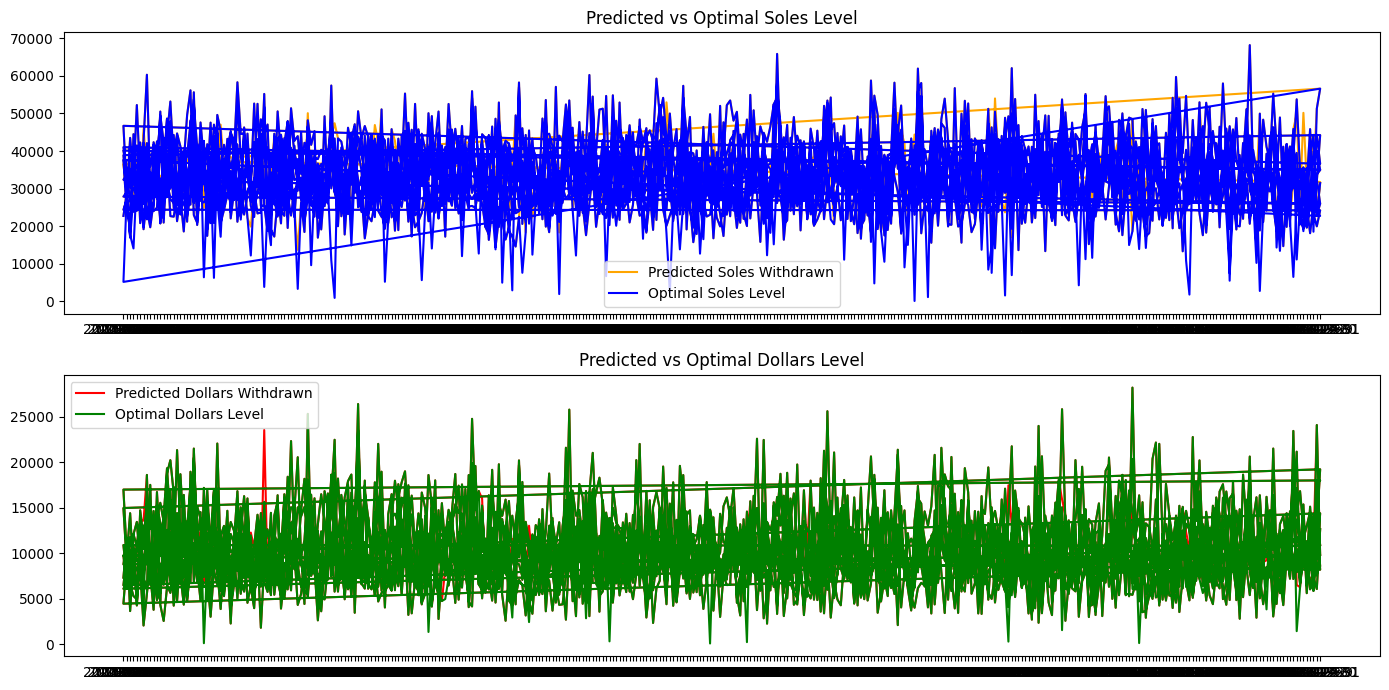

In [48]:
# Visualización de los resultados

# Soles
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data['Date'], data['Predicted_Soles_Withdrawn'], label='Predicted Soles Withdrawn', color='orange')
plt.plot(data['Date'], data['optimal_soles'], label='Optimal Soles Level', color='blue')
plt.title('Predicted vs Optimal Soles Level')
plt.legend()

# Dólares
plt.subplot(2, 1, 2)
plt.plot(data['Date'], data['Predicted_Dollars_Withdrawn'], label='Predicted Dollars Withdrawn', color='red')
plt.plot(data['Date'], data['optimal_dollars'], label='Optimal Dollars Level', color='green')
plt.title('Predicted vs Optimal Dollars Level')
plt.legend()

plt.tight_layout()
plt.show()